In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for i, (dirname, _, filenames) in enumerate(os.walk('/kaggle/input/25-indian-bird-species-with-226k-images/training_set')):
#    for filename in filenames:
#        print(f'{i}, {os.path.join(dirname, filename)}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

About the model
===============
This is the VGG16 implementation with Pytorch 
* Use VGG16, Batch Norm and image augmentation
* The accuracy is come to 80%.

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

from tqdm.auto import tqdm
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Define data set
===============
The parameters of object are the collection of file path and label combination and image augmentation function.  
ex:  
'/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Asian Green Bee-Eater/ML100845971.jpg_0'  
The "0" at the end is the label of this picture.

In [4]:
class ImDataset(Dataset):
    def __init__(self, path_set, tfm):
        self.files = path_set
        self.transform = tfm
    
    def __getitem__(self, idx):
        image_path, label = self.files[idx].rsplit("_", 1)
        with Image.open(image_path) as image:
            image = self.transform(image)
        
        return image, int(label)
    
    def __len__(self):
        return len(self.files)

Collect data
============
Collect the path of pictures and label the class, and then keep the picture with three channels.
* Each bird is a class
* Catenate the path and the class into "path_class"
* Filter out images with channels other than three.

After collecting the pictures, split the data into three parts: **training(80%)**, **validation(10%)** and **test(10%)**.

In [5]:
# Save filename_label, do random suffle and open image in dataset class
def allocate_data(path, val_ratio, test_ratio, seed):
    files = []
    train_ratio = 1-val_ratio-test_ratio

    for i, (dirname, _, filenames) in enumerate(os.walk(path)):
        for filename in filenames:
            with Image.open(os.path.join(dirname, filename)) as image:
                image = transforms.Compose([transforms.ToTensor()])(image)
                if image.shape[0] == 3:
                    files.append(f'{os.path.join(dirname, filename)}_{i}')
                    
    train_data, val_data, test_data = random_split(files, [train_ratio, val_ratio, test_ratio], generator=torch.Generator().manual_seed(seed))
    
    return train_data, val_data, test_data

Transform image
===============
Resize the images to `224x224` and convert the data type from PIL to Tensor.


In [6]:
# Transform function
train_tfm=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_tfm=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])  

Define model
============
Implement the **VGG16 model** + **Batch Norm** + **ReLU**(activation function)  

The image height and width will change by the convolution layer and max pooling, and follow the rule:  

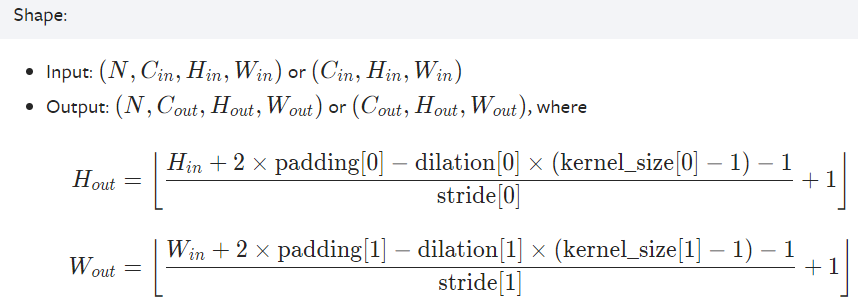

refer: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [7]:
# Model: VGG16
# H and W will be halved after maxpooling
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        
        self.nk = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                   # H and W = 112
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                   # H and W = 56
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                   # H and W = 28
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                   # H and W = 14
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                   # H and W = 7
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Linear(1000,25),
        )
    
    def forward(self, x):
        output = self.nk(x)
        output = output.view(output.size(0),-1)
        
        return self.fc(output)
        

In [8]:
file_path = "/kaggle/input/25-indian-bird-species-with-226k-images/training_set"
val_ratio = 0.1
test_ratio = 0.1
epochs = 35
lr = 1e-5
wd = 1e-5
batch_size = 32

In [9]:
train_data, val_data, test_data = allocate_data(file_path, val_ratio, test_ratio, seed)

In [10]:
train_set = ImDataset(train_data, train_tfm)
val_set   = ImDataset(val_data, train_tfm)
test_set  = ImDataset(test_data, train_tfm)
train_loader = DataLoader(train_set, batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size, shuffle=True, pin_memory=True)

Training section
================

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VGGModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=wd)
loss_fn = nn.CrossEntropyLoss()
best_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = []
    
    for im, label in tqdm(train_loader):
        predict = model(im.to(device))
        loss = loss_fn(predict, label.to(device)-1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc.append((predict.argmax(-1)+1==label.to(device)).float().mean())

    mtrain_loss = train_loss/len(train_loader)
    mtrain_acc = sum(train_acc)/len(train_acc)
    
    model.eval()
    val_loss = 0
    val_acc = []
    
    with torch.no_grad():
        for im, label in tqdm(val_loader):
            predict = model(im.to(device))
            loss = loss_fn(predict, label.to(device)-1)

            val_loss += loss.item()
            val_acc.append((predict.argmax(-1)+1==label.to(device)).float().mean())
        
    mval_loss = val_loss/len(val_loader)
    mval_acc = sum(val_acc)/len(val_acc)
        
    if mval_acc > best_acc:
        best_acc = mval_acc
        torch.save(model.state_dict(),"model.ckpt")
        print(f'{epoch+1}/{epochs}, tra_loss={mtrain_loss}, tra_acc={mtrain_acc}, val_loss={mval_loss}, val_acc={mval_acc} -> best')
    else:
        print(f'{epoch+1}/{epochs}, tra_loss={mtrain_loss}, tra_acc={mtrain_acc}, val_loss={mval_loss}, val_acc={mval_acc}')
        

  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

1/35, tra_loss=2.4216005437142027, tra_acc=0.2884525656700134, val_loss=2.0127738630267937, val_acc=0.410749226808548 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

2/35, tra_loss=1.5034337887721778, tra_acc=0.5487647652626038, val_loss=1.3328720700572914, val_acc=0.6032374501228333 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

3/35, tra_loss=1.0296283490889895, tra_acc=0.6965523958206177, val_loss=1.3100890945380843, val_acc=0.6306729316711426 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

4/35, tra_loss=0.7716138841304104, tra_acc=0.7710976004600525, val_loss=0.8868113693217157, val_acc=0.7427620887756348 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

5/35, tra_loss=0.5769302595241935, tra_acc=0.8269296884536743, val_loss=0.922070817628377, val_acc=0.7381162047386169


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

6/35, tra_loss=0.4205689853667158, tra_acc=0.8759526014328003, val_loss=0.934052006039821, val_acc=0.7387030720710754


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

7/35, tra_loss=0.3069869032739538, tra_acc=0.9102569222450256, val_loss=1.131248755354277, val_acc=0.7108763456344604


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

8/35, tra_loss=0.21016663652144174, tra_acc=0.9401118755340576, val_loss=0.8838015824136599, val_acc=0.7678012251853943 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

9/35, tra_loss=0.14188742866591278, tra_acc=0.961295485496521, val_loss=0.8551890707351792, val_acc=0.7761150002479553 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

10/35, tra_loss=0.09870573761254813, tra_acc=0.9734083414077759, val_loss=1.0011576548428602, val_acc=0.7547926306724548


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

11/35, tra_loss=0.07442617607426591, tra_acc=0.9797566533088684, val_loss=0.9578603178682462, val_acc=0.7805164456367493 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

12/35, tra_loss=0.06419715952639163, tra_acc=0.9830752015113831, val_loss=0.9916299883748444, val_acc=0.7700997591018677


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

13/35, tra_loss=0.06462376636156268, tra_acc=0.9821349382400513, val_loss=1.2774434454844033, val_acc=0.7356709837913513


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

14/35, tra_loss=0.06615948969976301, tra_acc=0.9805309772491455, val_loss=0.9178682177419394, val_acc=0.7786580324172974


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

15/35, tra_loss=0.04528949794944673, tra_acc=0.9877212643623352, val_loss=1.0631893978152476, val_acc=0.7821791768074036 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

16/35, tra_loss=0.05702911206084279, tra_acc=0.9831858277320862, val_loss=1.140719923754813, val_acc=0.7522495985031128


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

17/35, tra_loss=0.06160675133578479, tra_acc=0.980475664138794, val_loss=1.0570162110765216, val_acc=0.7747945785522461


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

18/35, tra_loss=0.018470212706855078, tra_acc=0.995532214641571, val_loss=0.8686381240545864, val_acc=0.8241392970085144 -> best


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

19/35, tra_loss=0.06036784810166542, tra_acc=0.9808075428009033, val_loss=1.0734312093593705, val_acc=0.7863849401473999


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

20/35, tra_loss=0.026575808824643707, tra_acc=0.9923242330551147, val_loss=1.2186856941438058, val_acc=0.7629597187042236


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

21/35, tra_loss=0.048081456327633686, tra_acc=0.9846792221069336, val_loss=0.9761950243526781, val_acc=0.7930849194526672


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

22/35, tra_loss=0.02635530125529019, tra_acc=0.9922013282775879, val_loss=0.8814610100128282, val_acc=0.822721004486084


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

23/35, tra_loss=0.03330278954750949, tra_acc=0.9891592860221863, val_loss=1.302388777615319, val_acc=0.7563086748123169


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

24/35, tra_loss=0.04038699862745022, tra_acc=0.987500011920929, val_loss=1.0135400861921444, val_acc=0.7968505620956421


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

25/35, tra_loss=0.028488723089273575, tra_acc=0.9916481971740723, val_loss=1.3136977607935247, val_acc=0.750880241394043


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

26/35, tra_loss=0.031989862138057226, tra_acc=0.990763247013092, val_loss=1.672911031565196, val_acc=0.730487048625946


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

27/35, tra_loss=0.0328242563534903, tra_acc=0.9900995492935181, val_loss=1.1479894892430642, val_acc=0.7700508236885071


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

28/35, tra_loss=0.032509715535043865, tra_acc=0.9893928170204163, val_loss=1.2519155160432132, val_acc=0.7784624099731445


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

29/35, tra_loss=0.025007486802889486, tra_acc=0.9921460151672363, val_loss=1.1196092518282608, val_acc=0.7890257835388184


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

30/35, tra_loss=0.026779906622951117, tra_acc=0.9916481971740723, val_loss=1.0282372351683362, val_acc=0.8020833134651184


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

31/35, tra_loss=0.02017919419292645, tra_acc=0.9947455525398254, val_loss=1.027807783912605, val_acc=0.798562228679657


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

32/35, tra_loss=0.03255246535782698, tra_acc=0.9890486598014832, val_loss=1.3118396024678793, val_acc=0.7749412655830383


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

33/35, tra_loss=0.0301369254237795, tra_acc=0.9906526803970337, val_loss=1.1709271035563777, val_acc=0.7958235144615173


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

34/35, tra_loss=0.01748929380139684, tra_acc=0.994800865650177, val_loss=1.2758608137218046, val_acc=0.7741588354110718


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

35/35, tra_loss=0.03655716137954372, tra_acc=0.9883419871330261, val_loss=1.1440787189443347, val_acc=0.7923023700714111


Test section
============

In [12]:
predict_list = []
label_list = []
total_loss = 0
total_acc = []

model = VGGModel().to(device)
model.load_state_dict(torch.load(f"model.ckpt"))
model.eval()

with torch.no_grad():
    for im, label in tqdm(test_loader):
        predict = model(im.to(device))
        loss = loss_fn(predict, label.to(device)-1)
        predict_list += (predict.argmax(-1)+1).tolist()
        label_list += label.to(device).tolist()
        
        total_loss += loss.item()
        total_acc.append((predict.argmax(-1)+1==label.to(device)).float().mean())

    mean_loss = total_loss/len(test_loader)
    mean_acc = sum(total_acc)/len(total_acc)

    print(f'{epoch+1}/{epochs}, loss={mean_loss}, acc={mean_acc}')

  0%|          | 0/71 [00:00<?, ?it/s]

35/35, loss=0.987677202048436, acc=0.7964103817939758


Export the result data
======================
Export the result data to a CSV file.

In [13]:
# Save predict value
df = pd.DataFrame()
df["ID"] = [ i for i in range(1, len(predict_list)+1)]
df["Predict Number"] = predict_list
df["Target Number"] = label_list

df.to_csv("predict_0329_1431.csv", index = False)